# CUHK [STAT3009](https://www.bendai.org/STAT3009/) Notebook4: ALS for Latent Factor Models II

## ALS for Latent factor model

- **Parameter**: 
  - \#Users: `n`
  - \#Items: `m`
  - latent factors for users: `P` 
  - latent factors for items: `Q`
  - tuning parameter: `lam`
  - \#Latent factors: `K`


- **Method**:
  - `fit`: input: `train_pair`, `train_rating`; output: fitted `P` and `Q`
  - `predict`: input: `test_pair`; output: predicted ratings
  - `rmse`: input: `test_pair`, `test_rating`; output: RMSE for the predicted ratings


In [1]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                # find all records from `item_id`
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    # if there is no record for `item_id`, set q_i = 0.
                    self.Q[item_id,:] = 0.
                    continue
                # compute the \sum p_u p_u^T and \sum r_{ui} p_u
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                # compute the q_i as a LSE
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

## Load and pro-processed dataset

In [2]:
import numpy as np
import pandas as pd

dtrain = pd.read_csv('./dataset/train.csv')
dtest = pd.read_csv('./dataset/test.csv')
## save real ratings for test set for evaluation.
test_rating = np.array(dtest['rating'])
## remove the ratings in the test set to simulate prediction
dtest = dtest.drop(columns='rating')

## convert string to user_id and item_id -> [user_id, item_id, rating]
# pre-process for training data
train_pair = dtrain[['user_id', 'movie_id']].values
train_rating = dtrain['rating'].values
# pre-process for testing set
test_pair = dtest[['user_id', 'movie_id']].values

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

## Fit and predict based on `LFM`

In [3]:
# fitting
shiing = LFM(n_user, n_item, K=3, lam=.0001)
shiing.fit(train_pair=train_pair, train_rating=train_rating)

Fitting Reg-LFM: K: 3, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.227 RMSE: 3.207
Reg-LFM: ite: 1; diff: 0.676 RMSE: 1.040
Reg-LFM: ite: 2; diff: 0.076 RMSE: 0.961
Reg-LFM: ite: 3; diff: 0.024 RMSE: 0.938
Reg-LFM: ite: 4; diff: 0.012 RMSE: 0.927
Reg-LFM: ite: 5; diff: 0.008 RMSE: 0.920
Reg-LFM: ite: 6; diff: 0.005 RMSE: 0.915
Reg-LFM: ite: 7; diff: 0.003 RMSE: 0.913
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.911
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.911


In [4]:
# pediction
pred_rating = shiing.predict(test_pair)

In [5]:
# evaluation
# rmse(test_rating, pred_rating)
# or we can just use
shiing.rmse(test_pair, test_rating)

1.1655499719771572

In [6]:
# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred

In [7]:
## Baseline + LFM
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)
# fit LFM RS by residual ratings 
shiing = LFM(n_user, n_item, K=3, lam=.0001)
shiing.fit(train_pair=train_pair, train_rating=train_rating_res)
pred = pred + shiing.predict(test_pair)

print('RMSE for glb + user_mean + LFM: %.3f' %rmse(test_rating, pred) )

Fitting Reg-LFM: K: 3, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.527 RMSE: 0.939
Reg-LFM: ite: 1; diff: 0.050 RMSE: 0.892
Reg-LFM: ite: 2; diff: 0.042 RMSE: 0.854
Reg-LFM: ite: 3; diff: 0.021 RMSE: 0.836
Reg-LFM: ite: 4; diff: 0.010 RMSE: 0.828
Reg-LFM: ite: 5; diff: 0.006 RMSE: 0.823
Reg-LFM: ite: 6; diff: 0.003 RMSE: 0.820
Reg-LFM: ite: 7; diff: 0.002 RMSE: 0.819
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.818
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.817
RMSE for glb + user_mean + LFM: 0.975


## Which `lam` and `K` is best for prediction?

- Grid search based on cross-validation
- models with different `lam` and `K`: print CV rmse score

In [8]:
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.797, valid_rmse: 1.282
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.789, valid_rmse: 1.266
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.792, valid_rmse: 1.250
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.767, valid_rmse: 1.074
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.768, valid_rmse: 1.093
3-Fold CV for K: 2; lam: 0.00000: train_rmse: 0.775, valid_rmse: 1.094
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.779, valid_rmse: 1.037
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.771, valid_rmse: 1.039
3-Fold CV for K: 2; lam: 0.00001: train_rmse: 0.778, valid_rmse: 1.020
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.780, valid_rmse: 0.988
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.781, valid_rmse: 0.977
3-Fold CV for K: 2; lam: 0.00003: train_rmse: 0.788, valid_rmse: 1.002
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 0.821, valid_rmse: 0.949
3-Fold CV for K: 2; lam: 0.00010: train_rmse: 0.816, valid_rmse: 0.965
3-Fold

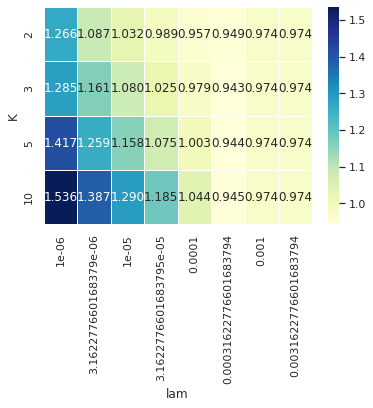

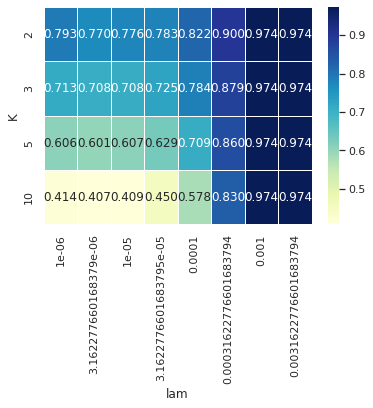

In [9]:
## CV based on `LFM_CV`
## Baseline + LFM
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_ratings=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)
# fit LFM_CV by residual ratings 
Ks, lams = [2, 3, 5, 10], 10**np.arange(-6, -2, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [10]:
## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
print('RMSE for glb + user_mean + LFM: %.3f' %rmse(test_rating, pred))

Fitting Reg-LFM: K: 3, lam: 0.00032
Reg-LFM: ite: 0; diff: 0.515 RMSE: 0.966
Reg-LFM: ite: 1; diff: 0.003 RMSE: 0.963
Reg-LFM: ite: 2; diff: 0.019 RMSE: 0.945
Reg-LFM: ite: 3; diff: 0.025 RMSE: 0.921
Reg-LFM: ite: 4; diff: 0.011 RMSE: 0.910
Reg-LFM: ite: 5; diff: 0.005 RMSE: 0.906
Reg-LFM: ite: 6; diff: 0.002 RMSE: 0.904
Reg-LFM: ite: 7; diff: 0.001 RMSE: 0.903
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.902
Reg-LFM: ite: 9; diff: 0.000 RMSE: 0.902
RMSE for glb + user_mean + LFM: 0.979
